# Named entity recognition

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

## Tasks

### Read the classification of [Named Entities](http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf).
### Read the [API of NER](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki) in [Clarin](http://ws.clarin-pl.eu/ner.shtml).
### Read the [documentation of CLL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).

In [24]:
import regex
import os
import collections
import random
import requests
import xml.etree.ElementTree as ET
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint

### Randomly select 100 bills.

In [2]:
def files_names():
    path = '../ustawy'
    absolute_path = os.path.realpath(path) + "\\"
    return [(absolute_path + filename, filename) for filename in os.listdir(path)]

def get_file_text_raw(filename):
    with open(filename, 'r', encoding="utf8") as content_file:
        return content_file.read()

def get_file_text(filename):
    return get_file_text_raw(filename).replace('-\n', '').replace('\n', ' ').replace('  ', ' ')

bills = random.sample(files_names(), 100)

### Recognize the named entities in the documents using the `n82` model.

In [6]:
url = "http://ws.clarin-pl.eu/nlprest2/base" 
def upload(filename):    
    text = get_file_text_raw(filename)
    r = requests.post(url=url + '/startTask',
                             json={
                                 'text': text,
                                 'lpmn': 'any2txt|wcrft2|liner2({"model":"n82"})',
                                 'user': '',
                             })
    if r.status_code == 200:
        print("sentOk: " + filename)
        return r.content.decode("utf-8")
    else:
        print("sentErr: " + filename)
        return None
    
def process(task_id, filename):
    data = requests.get(url + '/getStatus/' + task_id).json()
    while data["status"] == "QUEUE" or data["status"] == "PROCESSING" :
        time.sleep(0.5)
        data = requests.get(url + '/getStatus/' + task_id).json()
    if data["status"]=="ERROR":
        print("Error "+filename)
        print("Error "+data["value"])
        return None
    path = './ner'
    absolute_path = os.path.realpath(path) + "\\" + filename
    with open(absolute_path, 'w', encoding="utf-8") as file:
        file.write(requests.get(url=url + '/download' + data['value'][0]['fileID']).content.decode("utf-8"))
    print("Ok: " + filename)
    print("Ok: " + task_id)
    return "Ok"
    
task_ids = [upload(bill[0]) for bill in bills]
status = [process(task_id, bill[1]) for task_id, bill in zip(task_ids, bills) if task_id is not None]

Ok: 1999_932.txt
Ok: 462113b9-6e35-4e75-b8d9-06ee4d0a27b9
Ok: 2004_1536.txt
Ok: e98d6bab-bb37-4b51-9241-1b8225d4396e
Ok: 2003_2125.txt
Ok: a107cc38-7c9b-4dc5-b2c4-f7711ddd09d3
Ok: 2000_867.txt
Ok: 6a711a34-36e2-4221-8db5-7c9488cf3d98
Ok: 1997_692.txt
Ok: de876a16-040b-4870-82a6-8b999eeecbdf
Ok: 2001_744.txt
Ok: dfc7376f-81d8-4a77-9daf-869aa2b19d9b
Ok: 2004_1801.txt
Ok: f15fac1e-88c6-4b63-9e83-f2ea157eaef8
Ok: 2004_625.txt
Ok: d9d4679a-ca94-4e6c-ba1c-8232c00456af
Ok: 2003_535.txt
Ok: c261df30-501e-48be-9c02-62b07c34deb0
Ok: 1997_592.txt
Ok: 2d0829a4-6836-474f-84c7-d4093f562bef
Ok: 1998_1065.txt
Ok: 0ea0824c-9b37-4880-9a23-e27996668c74
Ok: 2001_1380.txt
Ok: d9ce05b5-98d5-4f3a-a8ca-e9000f131d4b
Ok: 2003_335.txt
Ok: 82638709-c29a-42c5-b34b-d5aad2615476
Ok: 1996_128.txt
Ok: 3c0522e3-876d-43f9-a5cd-355e2d52b38f
Ok: 2001_1050.txt
Ok: b5cca6c7-68a3-452c-b66b-f218731b0c46
Ok: 2003_1725.txt
Ok: 3116164c-6b7a-4fb2-8f8e-a542fe96cd61
Ok: 2001_124.txt
Ok: 674a3bc5-8f13-4302-a336-c9a86f9cc4d4
Ok: 200

In [9]:
def get_xml(filename):
    path = './ner'
    absolute_path = os.path.realpath(path) + "\\" + filename
    return ET.parse(absolute_path).getroot()

In [18]:
full = {}
general = {}

for bill in bills:
    root = get_xml(bill[1])
    for sen in root.findall('chunk/sentence'):
        words = {}
        for tok in sen.findall('tok'):
            word = tok.find('lex').find('base').text
            for ann in tok.findall('ann'):
                chan = ann.attrib['chan']
                num = ann.text
                if chan not in words:
                    words[chan] = {}
                if num not in words[chan]:
                    words[chan][num] = word
                else:
                    words[chan][num] = ' '.join([words[chan][num], word])
        for chan in words.keys():
            value = list(words[chan].values())
            general_chan = '_'.join(chan.split('_')[:2])
            if chan not in full.keys():
                full[chan] = value
            else:
                full[chan].extend(value)
            if general_chan not in general.keys():
                general[general_chan] = value
            else:
                general[general_chan].extend(value)

### Plot the frequency of the recognized classes:
1. fine-grained classification histogram (classes such as `nam_fac_bridge`, `nam_liv_animal`).
1. coarse-grained classification histogram (classes such as `nam_adj`, `nam_eve`, `nam_fac`).

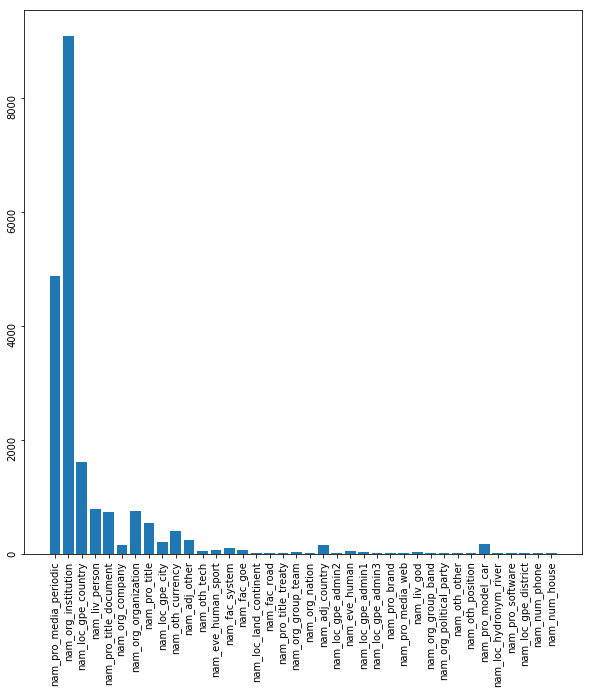

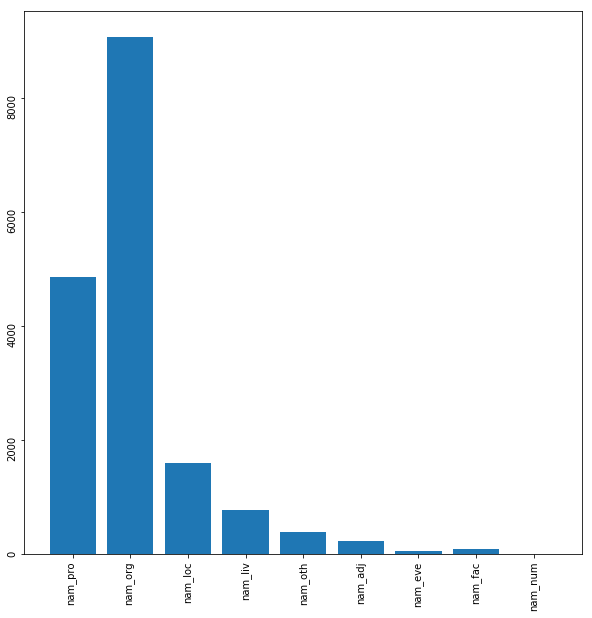

In [19]:
def plot_histogram(values, labels):
    x = np.arange(len(values))
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.bar(x, values)
    plt.xticks(x, labels)
    plt.tick_params(labelrotation=90)
    plt.show()
    
def plot_histogram_from_dict(dic):
    plot_histogram([len(dic[k]) for k in dic.keys()], dic.keys())

plot_histogram_from_dict(full)
plot_histogram_from_dict(general)

### Display 50 most frequent Named Entities including their count and fine-grained type.

In [21]:
full_counter = Counter()
for chan in full.keys():
    for v in full[chan]:
        full_counter[(v, chan)] += 1
full_list = list(full_counter.items())
full_list.sort(key=lambda x: -x[1])
full_list[:50]

[(('Dzieje_(Apostolskie) . u .', 'nam_pro_media_periodic'), 865),
 (('rzeczpospolita polski', 'nam_loc_gpe_country'), 505),
 (('minister sprawiedliwość', 'nam_org_institution'), 462),
 (('Times', 'nam_pro_media_periodic'), 410),
 (('dziennik . u .', 'nam_pro_media_periodic'), 392),
 (('minister obrona narodowy', 'nam_org_institution'), 274),
 (('skarb państwo', 'nam_org_institution'), 252),
 (('fundusz praca', 'nam_org_institution'), 199),
 (('szef służba cywilny', 'nam_org_institution'), 198),
 (('prezes rad minister', 'nam_org_institution'), 192),
 (('złoty', 'nam_oth_currency'), 177),
 (('sąd najwyższy', 'nam_org_institution'), 146),
 (('rada minister', 'nam_org_institution'), 132),
 (('prezes agencja', 'nam_org_institution'), 124),
 (('prezes urząd', 'nam_org_institution'), 122),
 (('Times Newa Roman', 'nam_pro_media_periodic'), 92),
 (('Rzeczpospolita Polska', 'nam_loc_gpe_country'), 88),
 (('Times Newa Roman', 'nam_pro_title'), 88),
 (('agencja', 'nam_org_institution'), 86),
 (('

### Display 10 most frequent Named Entities for each coarse-grained type.

In [25]:
for chan in general.keys():
    print('-------------------------------------------------------')
    print(chan)
    chan_counter = Counter()
    for v in general[chan]:
        chan_counter[v] += 1
    chan_list = list(chan_counter.items())
    chan_list.sort(key=lambda x: -x[1])
    pprint(chan_list[:10])
    print('------------------------------------------------------')


-------------------------------------------------------
nam_pro
[('Dzieje_(Apostolskie) . u .', 865),
 ('Times', 410),
 ('dziennik . u .', 392),
 ('Times Newa Roman', 92),
 ('znak', 58),
 ('z 2001 r .', 44),
 ('dziennik . URz', 32),
 ('monitor Polska', 24),
 ('z 1997 r .', 24),
 ('ordynacja podatkowy', 22)]
------------------------------------------------------
-------------------------------------------------------
nam_org
[('minister sprawiedliwość', 462),
 ('minister obrona narodowy', 274),
 ('skarb państwo', 252),
 ('fundusz praca', 199),
 ('szef służba cywilny', 198),
 ('prezes rad minister', 192),
 ('sąd najwyższy', 146),
 ('rada minister', 132),
 ('prezes agencja', 124),
 ('prezes urząd', 122)]
------------------------------------------------------
-------------------------------------------------------
nam_loc
[('rzeczpospolita polski', 505),
 ('Rzeczpospolita Polska', 88),
 ('Polska', 84),
 ('Warszawa', 47),
 ('rzeczpospolita Polska', 16),
 ('republika federalny Niemcy', 6),
 

### Discuss the results of the extraction.

Ner wydaje się być przydatym narzedziem, ponieważ potrafi rozpoznac encje oraz określić ich typ.

Nardzedzie z dziwnego powodu stworzyło encje Dzieje_(Apostolskie)

## Hints

1. Named entity recognition is a process aimed at the identification of entities mentioned in text by determining their
   scope and classifying them to a predefined type. The larger the number of types, the more difficult the problem is.
1. Named entities are usually proper names and temporal expressions. They usually convey the most important information
   in text.
1. IOB format is typically used to tag names entities. The name (IOB) comes from the types of tokens (_in_, _out_, _beginning_).
   The following example shows how the format works:
   ```
   W            O
   1776         B-TIME
   niemiecki    O
   zoolog       O
   Peter        B-PER
   Simon        I-PER
   Pallas       I-PER
   dokonał      O
   formalnego   O
   ...
   ```
1. The set of classes used in NER is partially task dependant. Some general classes such as names of people or cities
   are used universally, but categories such as references to law regulations is specific to legal information systems.